In [72]:
# Data Tools
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import sem

# Visualization Tools
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Test/Train Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

# Helpful Functions
# Reference: https://people.duke.edu/~rnau/mathreg.htm
def standard_error(x_test, y_test, y_pred):
    n = len(y_test)
    e = y_test - y_pred
    RSS = (e**2).sum()
    sigma = math.sqrt(RSS / (n - 2)) # estimation of standard deviation (aka residual standard error)
    SE = sigma**2 / np.sum((x_test - x_test.mean())**2)
    return math.sqrt(SE)

def residual_standard_error(y_test, y_pred):
    e = y_test - y_pred
    RSS = (e**2).sum()
    RSE = math.sqrt(RSS / (len(y_test) - 2))
    return RSE

def f_statistic(y_test, y_pred, p):
    n = len(y_test)
    e = y_test - y_pred
    RSS = (e**2).sum()
    TSS = ((y_test - y_test.mean())**2).sum()
    F = ((TSS - RSS)/p) / RSS * (n - p - 1)
    return F

def print_coefficient_stats(x_test, y_test, y_pred, lr):
    print('\n=== Coefficient Summary ===')

    for i in range(len(x_test.columns)):
        print('\n' + str(x_test.columns[i]).center(len(x_test.columns[i]) + 2, ' ').center(30, '-'))
        # Coefficient
        print('Coefficient: {:0.4f}'.format(lr.coef_[i]))

        # Standard Error
        print('Standard Error: {:0.4f}'.format(standard_error(x_test[x_test.columns[i]], y_test, y_pred)))
        
        # t-statistic
        t_stat = (lr.coef_[i] / standard_error(x_test[x_test.columns[i]], y_test, y_pred))
        print('T-Statistic: {:0.4f}'.format(t_stat))

        # p Value
        p_val = stats.t.sf(np.abs(t_stat), len(x_test[x_test.columns[i]]) - 1) * 2
        print('P Value: {:0.4f}'.format(p_val))

    # Intercept
    print('\n' + str('Intercept').center(len('Intercept') + 2, ' ').center(30, '-'))
    print('Coefficient: {:0.4f}'.format(lr.intercept_))

def coefficient_stats(x_test, y_test, y_pred, lr):
    df_array = []
    headings = ['Feature', 'Coefficient', 'Standard Error', 'T_Statistic', 'p Value']
    for i in range(len(x_test.columns)):
        feature = x_test.columns[i]
        SE = standard_error(x_test[feature], y_test, y_pred)
        t_stat = (lr.coef_[i] / standard_error(x_test[feature], y_test, y_pred))
        p_val = stats.t.sf(np.abs(t_stat), len(x_test[feature] - 1) * 2)
        df_array.append([
            feature,
            lr.coef_[i],
            SE,
            t_stat,
            p_val
        ])
    return pd.DataFrame(df_array, columns=headings)

metric_funcs = [explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_error, mean_squared_log_error, median_absolute_error, residual_standard_error, r2_score]

def print_regression_metrics(y_test, y_pred, metric_funcs):
    print('=== Statistics Summary ===')

    for func in metric_funcs:
        print(func.__name__ + ': {:0.4f}'.format(func(y_test, y_pred)))

def regression_metrics(y_test, y_pred, metric_funcs, p=False):
    df_array = []
    headings = ['Metric', 'Value']

    for func in metric_funcs:
        df_array.append([
            ' '.join([x.capitalize() for x in func.__name__.split('_')]),
            func(y_test, y_pred)
        ])

    # F-Statistic
    if p:
        df_array.append([
            'F-Statistic',
            f_statistic(y_test, y_pred, p)
        ])

    return pd.DataFrame(df_array, columns=headings)

In [59]:
df = pd.read_csv('data/Advertising.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

## Data Exploration

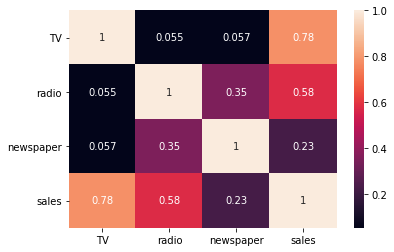

In [60]:
sns.heatmap(df.corr(), annot=True)

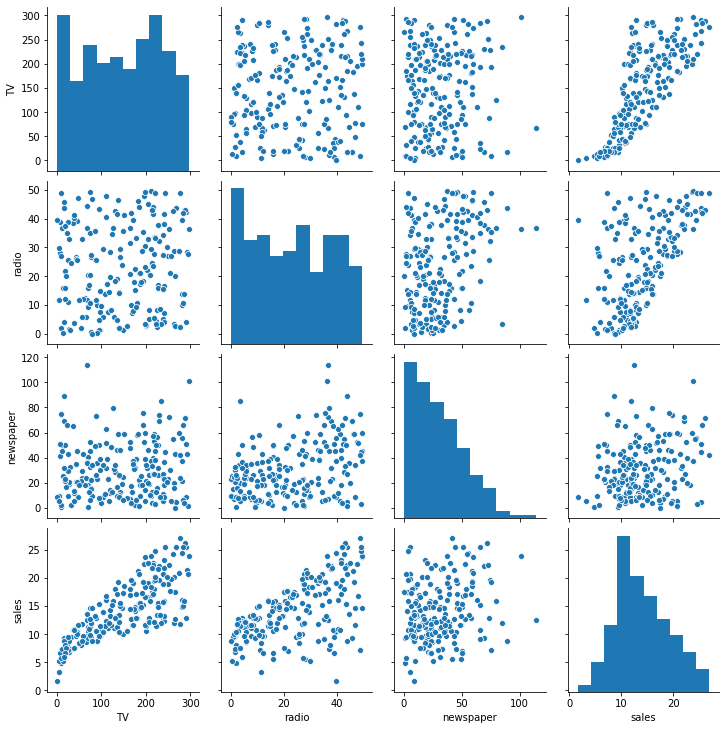

In [61]:
sns.pairplot(df)

## Test/Train Split

In [62]:
train, test = train_test_split(df, test_size=0.25)

## Model Building

In [63]:
lr = LinearRegression()
lr.fit(train.drop('sales', axis=1), train.sales)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
y_pred = lr.predict(test.drop('sales', axis=1))

## Model Assessment

In [65]:
print_regression_metrics(test.sales, y_pred, metric_funcs)

=== Statistics Summary ===
explained_variance_score: 0.9313
mean_absolute_error: 1.1301
mean_squared_error: 2.0271
mean_squared_error: 2.0271
mean_squared_log_error: 0.0151
median_absolute_error: 1.0496
r2_score: 0.9298
residual_standard_error: 1.4531


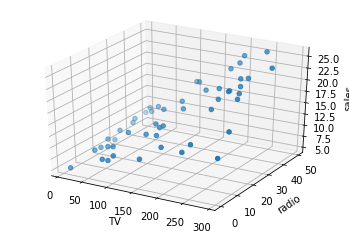

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = test.TV
y = test.radio
z = test.sales

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

ax.scatter(x, y, z)

plt.show()

## Coefficient Analysis

In [67]:
# Print all coefficients -- TRAIN DATA
for i in range(len(lr.coef_)):
    print(train.drop('sales', axis=1).columns[i] + ': {:0.4f}'.format(lr.coef_[i]))

print('Intercept: {:0.4f}'.format(lr.intercept_))

TV: 0.0455
radio: 0.1860
newspaper: 0.0018
Intercept: 2.8995


## Simple Linear Regression

In [68]:
# Single Linear Regression
lr3 = LinearRegression()
lr3.fit(df.TV.values.reshape((-1, 1)), df.sales)
y_pred = lr3.predict(df.TV.values.reshape((-1, 1)))
display(regression_metrics(df.sales, y_pred, metric_funcs))
display(coefficient_stats(df.drop(['sales', 'newspaper', 'radio'], axis=1), df.sales, y_pred, lr3))

,Metric,Value
0,Explained Variance Score,0.611875
1,Mean Absolute Error,2.549806
2,Mean Squared Error,10.512653
3,Mean Squared Error,10.512653
4,Mean Squared Log Error,0.047546
5,Median Absolute Error,2.026365
6,R2 Score,0.611875
7,Residual Standard Error,3.258656


,Feature,Coefficient,Standard Error,T_Statistic,p Value
0,TV,0.047537,0.002691,17.667626,2.374948e-52


## Multiple Linear Regression

In [71]:
# Multiple Linear Regression

# Fitting data
lr2 = LinearRegression()
lr2.fit(df.drop('sales', axis=1), df.sales)

# Assessing
y_pred = lr2.predict(df.drop('sales', axis=1))
display(regression_metrics(df.sales, y_pred, metric_funcs, 3))
display(coefficient_stats(df.drop('sales', axis=1), df.sales, y_pred, lr2))

# TODO: Need to fix coefficient stats for multiple linear regression
# TODO: Need to include intercept in the calculations

,Metric,Value
0,Explained Variance Score,0.897211
1,Mean Absolute Error,1.252011
2,Mean Squared Error,2.784126
3,Mean Squared Error,2.784126
4,Mean Squared Log Error,0.030333
5,Median Absolute Error,1.075512
6,R2 Score,0.897211
7,Residual Standard Error,1.676976
8,F-Statistic,570.270704


,Feature,Coefficient,Standard Error,T_Statistic,p Value
0,TV,0.045765,0.001385,33.051525,1.003978e-116
1,radio,0.188530,0.008007,23.545792,7.626142e-78
2,newspaper,-0.001037,0.005458,-0.190071,4.246751e-01


## Variable Selection

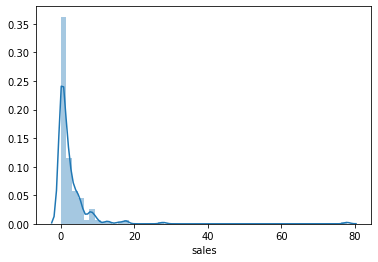

In [74]:
sns.distplot((df.sales - y_pred)**2)